In [1]:
from dataclasses import dataclass
import tensorflow as tf
import numpy as np


@dataclass
class TfPoly:
    """Piecewise polynomial, similar to scipy.interpolate.PPoly.
        p(t) = sum_i c[i,j] (t - x[j]) ** i, x[j] <= t < x[j + 1]
    """

    x: tf.Tensor
    c: tf.Tensor

    def __post_init__(self):
        self.x = tf.convert_to_tensor(self.x, dtype=tf.float64)
        self.c = tf.convert_to_tensor(self.c, dtype=tf.float64)
        tf.debugging.assert_rank(self.x, 1)
        tf.debugging.assert_rank(self.c, 2)
        tf.debugging.assert_equal(tf.shape(self.x)[0], 1 + tf.shape(self.c)[1])

    def __call__(self, t):
        "Evaluate p(t)"
        # does not use horners scheme but it's probably ok
        t = tf.convert_to_tensor([t], dtype=tf.float64)
        i = tf.searchsorted(self.x, t, side="right") - 1
        ci = tf.gather(self.c, i, axis=1)  # [D, T]
        ti = t - tf.gather(self.x, i, axis=0)  # [T]
        i = tf.range(ci.shape[0], dtype=tf.float64)[::-1, None]
        return tf.reduce_sum(ci * tf.math.pow(ti[None], i), axis=0)[0]  # [T]
        # return tf.math.polyval(
        #     list(tf.gather(self.c, i, axis=1)), t - tf.gather(self.x, i, axis=0)
        # )

    def antiderivative(self):
        k, n = self.c.shape
        c0 = (1. / tf.range(1, k + 1, dtype=self.c.dtype))[::-1, None] * self.c
        i = 1 + tf.range(c0.shape[0], dtype=c0.dtype)[::-1, None]
        x0 = self.x[1:-1] - self.x[:-2]
        c1 = tf.concat(
            [
                [0.],
                tf.math.cumsum(
                    tf.math.reduce_sum(c0[:, :-1] * tf.math.pow(x0[None], i), axis=0)
                ),
            ],
            axis=0,
        )
        return TfPoly(x=self.x, c=tf.concat([c0, c1[None]], axis=0))

    def inverse(self):
        """Return the inverse of this function. Only valid for continuous,
        strictly monotone, piecewise linear functions; this assumption is not
        checked.
        """
#         assert self.c.shape[0] == 2, self.c.shape
        breaks = self.c[1]  # [0, p(t1), p(t2), ...]
        return TfPoly(
            x=tf.concat([breaks, [np.inf]], axis=0),
            c=tf.concat([1. / self.c[:1], [self.x[:-1]]], axis=0),
        )




In [2]:
eta = TfPoly(x=np.r_[0, np.geomspace(1e-3, 20, 5), np.inf], c=np.reshape(np.random.rand(6),(1,-1)))
R_real = eta.antiderivative()
R_real_inv = R_real.inverse()

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU,LocallyConnected1D,Dropout,MaxPooling1D, Flatten,ReLU,BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.regularizers import l1_l2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
H_learned = 24
seq_len = 300
learning_rate = 0.005
batch_size = 30
EPOCHES = 2000



In [15]:
def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]
    # return tf.constant(.8, tf.float32)


def rexp():
    return -tf.math.log(runif())


def exprelu(x):
    return tf.where(x > 0, tf.math.expm1(x), tf.zeros_like(x))


def reloid(x):
    "(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])"
    return tf.concat([tf.nn.sigmoid(x[:-1]), tf.math.exp(x[-1:])], axis=0)


# @tf.function
def reloid_derivative(x):
    return tf.concat(
        [
            tf.nn.sigmoid(x[:-1])
            * (1 - tf.nn.sigmoid(x[:-1])),  # derivative of sigmoid
            tf.math.exp(x[-1:]),
        ],
        axis=0,
    )


# @tf.function
def S(x, w, v, b):
    """
    x: scalar
    w, v, b: (3, H)
    """
    x = tf.convert_to_tensor(x, dtype="float64")
    # tf.debugging.assert_positive(x, message="R: x>0")
    exp_w_v = tf.math.exp([w, v])
    ew = exp_w_v[0]
    ev = exp_w_v[1]
    # b = tf.math.sigmoid(b) # try this  # JT - bug. was sigb
    ew = tf.concat([ew[:-1], tf.ones_like(ew[-1:]),], axis=0,)
    x = tf.reshape(x, (1, 1))
    return tf.transpose(ev) @ reloid(ew @ x + b)


# @tf.function
def R(x, w, v, b):
    return S(tf.math.log(x), w, v, b)


# @tf.function
def Rinv(y, w, v, b):
    y = tf.convert_to_tensor(y, dtype="float64")
    # y = tf.reshape(y, (-1,))[0]
    # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
    # fixme: calculate this exactly.
    x_left = tf.convert_to_tensor([[0.0]], tf.float64)
    x_right = tf.convert_to_tensor([[1e8]], tf.float64)
    # tf.print((x_left, x_right))
    # tf.print("y", y)
    # tf.print('y',y)
    # tf.debugging.assert_greater(R(x_right, w, v, b), y, message="R(x_right)>y inv")

    def cond(xl, xr):
        # tf.print(xl, xr)
        xi = (xl + xr) / 2.0
        yi = R(xi, w, v, b)[0, 0]
        return abs(y - yi) > 1e-6

    def body(xl, xr):
        xi = (xl + xr) / 2.0
        yi = R(xi, w, v, b)[0, 0]
        left = tf.cast(yi < y, dtype="float64")
        xl = left * xi + (1.0 - left) * xl
        xr = (1.0 - left) * xi + left * xr
        return (xl, xr)
        # print(y, x_i, y_i)

    xl, xr = tf.while_loop(cond, body, (x_left, x_right))
    return (xl + xr) / 2.0


@tf.custom_gradient
def custom_Rinv(y, w, v, b):
    y = tf.convert_to_tensor(y, dtype="float64")
    x = Rinv(y, w, v, b)
    with tf.GradientTape() as g:
        g.watch([x, w, v, b])
        y = R(x, w, v, b)
    dR_dw, dR_dv, dR_db, dR_dx = g.gradient(y, [w, v, b, x])

    def grad(dx):
        return dx / dR_dx, -dx * dR_dw / dR_dx, -dx * dR_dv / dR_dx, -dx * dR_db / dR_dx

    return x, grad

In [16]:
mu = 1e-4
rho = 1e-5


def _gen_gaps(k: int, _R, _Rinv,) -> tf.Tensor:
    """Return k gaps sampled from genetic distribution with rate function eta."""
    z = tf.convert_to_tensor([rexp()])
    x = _Rinv(z)  # initialize x by sampling from prior
    x = tf.reshape(x, [1,1])
    tf.debugging.assert_positive(x, message="gen_gaps first x")

    gap = tf.constant([[0.0]], dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 1)

    while tf.less(j, k + 1):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor(u * x)
        r_u_x = _R(u_x[0])  # compute R(u_x)
        x = _Rinv(z + r_u_x)  # segment height
        x = tf.reshape(x, [1,1])
        # tf.print(x)
        # tf.print(z+r_u_x,"\n")
        with tf.control_dependencies(
            [
                tf.debugging.assert_all_finite(x, "second x"),
                tf.debugging.assert_positive(x, message="gen_gaps second x"),
            ]
        ):
            next_event = rexp() / (x * (mu + rho))
            tf.debugging.assert_positive(next_event, message="gen_gaps first gap")
            gap += next_event  # length to next event
        while runif() < (mu / (mu + rho)) and tf.less(j, k + 1):
            ta = ta.write(j, gap)
            gap *= 0.0
            j += 1
            next_event = rexp() / (x * (mu + rho))
            tf.debugging.assert_positive(next_event, message="gen_gaps second gap")
            gap += next_event  # length to next event

    gaps = ta.stack()[1:]  # first obs suffers from inspection paradox?
    with tf.control_dependencies(
        [
            tf.debugging.assert_positive(
                gaps, message="gaps have non-positive entry", summarize=100
            )
        ]
    ):
        return gaps

In [17]:
# @tf.function
def gen_gaps(
    w, v, b, k,
):
    R_ = lambda x: R(x, w, v, b)
    Rinv_ = lambda z: custom_Rinv(z, w, v, b)
    return _gen_gaps(k, R_, Rinv_)


# @tf.function
def gen_gaps_real(k: int,):
    return _gen_gaps(k, R_real, R_real_inv,)

In [18]:
class CustomGenGaps(keras.layers.Layer):
    """Take one parameter H as input
    Then construct one hidden layer with H units"""

    def __init__(self, H, name="gen_gaps_layer"):
        super(CustomGenGaps, self,).__init__(name=name)
        init = tf.random_normal_initializer(stddev=1)
        self.w = self.add_weight(
            shape=(H, 1),
            initializer=init,
            dtype="float64",
            trainable=True,
            name="w",
        )
        self.v = self.add_weight(
            shape=(H, 1),
            initializer=init,
            dtype="float64",
            trainable=True,
            name="v",
        )
        self.b = self.add_weight(
            shape=(H, 1),
            initializer=init,
            dtype="float64",
            trainable=True,
            name="b",
        )

    def call(self, length):
        return tf.reshape(gen_gaps(self.w, self.v, self.b, length), [1, length])


class Generator(keras.Model):
    """ wrap the GenGaps layer into Keras Model """

    def __init__(self, H):
        super(Generator, self).__init__()
        self.GenLayer = CustomGenGaps(H)

    def call(self, inputs, training=True):
        return self.GenLayer(inputs)
    
generator = Generator(H_learned)

In [19]:
def SSE(x, generator):
    """ Calculate difference between real and learned function """
    r_hat = R_learned(x, generator)[0]
    r = R_real(x)
    x = tf.cast(x, "float64")
    return tf.math.sqrt(tf.math.square(r_hat - r)) * tf.math.exp(
        -x
    )  # make integral convergent

In [20]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images.
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

In [21]:

def integral(y, x):
    """Trapezoidal Method"""
    y = tf.cast(y, "float64")
    x = tf.cast(x, "float64")
    dx = (x[-1] - x[0]) / (int(x.shape[0]) - 1)
    return ((y[0] + y[-1]) / 2 + tf.reduce_sum(y[1:-1])) * dx

In [22]:
discriminator = Sequential(
    [
     Input(shape=(seq_len,1)),
     LocallyConnected1D(128, 4),
     BatchNormalization(),
     ReLU(),
     MaxPooling1D(),
        
     LocallyConnected1D(64, 4),
     BatchNormalization(),
     ReLU(),
     MaxPooling1D(),
     Flatten(),
     Dense(1)
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d (Locally (None, 297, 128)          190080    
_________________________________________________________________
batch_normalization (BatchNo (None, 297, 128)          512       
_________________________________________________________________
re_lu (ReLU)                 (None, 297, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 128)          0         
_________________________________________________________________
locally_connected1d_1 (Local (None, 145, 64)           4760640   
_________________________________________________________________
batch_normalization_1 (Batch (None, 145, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 145, 64)         

In [23]:
def discriminator_objective(d_x, g_z):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(
        tf.ones_like(d_x), d_x
    )  # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(
        tf.zeros_like(g_z), g_z
    )  # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss

    return total_loss

In [24]:
generator_optimizer = optimizers.Adam(learning_rate)
discriminator_optimizer = optimizers.Adam(learning_rate)

In [25]:
m = tf.keras.metrics.BinaryAccuracy()

# @tf.function
def training_step(generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_seq = tf.squeeze(tf.stack([generator(seq_len) for _ in range(batch_size)]))
        real_seq = tf.squeeze(tf.stack([tf.reshape(gen_gaps_real(seq_len), (1, seq_len))\
                                      for _ in range(batch_size)]))
        d_x_true = discriminator(tf.expand_dims(tf.math.log(real_seq),-1))
        d_x_fake = discriminator(tf.expand_dims(tf.math.log(fake_seq),-1))
        
        discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
        # Adjusting Gradient of Discriminator
        gradients_of_discriminator = disc_tape.gradient(
            discriminator_loss, discriminator.trainable_variables
        )
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )  # Takes a list of gradient and variables pairs

        generator_loss = generator_objective(d_x_fake)
        # Adjusting Gradient of Generator
        gradients_of_generator = gen_tape.gradient(
            generator_loss, generator.trainable_variables
        )
        for i in range(3):
            generator_optimizer.apply_gradients(
                zip([gradients_of_generator[i]], [generator.trainable_variables[i]])
            )
    m.reset_states()
    m.update_state(tf.ones_like(d_x_true),tf.math.sigmoid(d_x_true))
    real_acc = m.result()

    m.reset_states()
    m.update_state(tf.zeros_like(d_x_fake),tf.math.sigmoid(d_x_fake))
    fake_acc = m.result()

    return generator_loss, discriminator_loss, real_acc, fake_acc

In [26]:
def training(epoches):
#     warnings.filterwarnings("ignore")
    for epoch in range(epoches + 1):
        mse.append(integral(np.array([SSE(i, generator) for i in x_li]), x_li))
        gen_loss,disc_loss,real,fake = training_step(generator, discriminator)
        d_loss.append(disc_loss)
        g_loss.append(gen_loss)
        real_acc.append(real)
        fake_acc.append(fake)
        if (epoch % 20) == 0:
            print(
                "epoch=%d generator_loss=%f discriminator_loss=%f real_acc=%f fake_acc=%f"
                % (epoch, gen_loss, disc_loss, real, fake)
            )
            performance_check(generator)

In [27]:
training_step(generator, discriminator)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7288813>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.3807799>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [28]:
x_li = tf.convert_to_tensor(np.geomspace(1e-2, 10, num=200), dtype="float64")

grad_real = []
for x in x_li:
    with tf.GradientTape() as g:
        g.watch(x)
        y = R_real(x)
    grad_real.append(g.gradient(y, x))
    
y_real = [R_real(i) for i in x_li]

def R_learned(x, generator):
    return R(x, generator.weights[0], generator.weights[1], generator.weights[2])

def performance_check(generator):
    plt.figure(figsize=(13, 4))
    plt.subplot(131)
    # Real Generator Plot
    plt.plot(tf.reshape(x_li, [-1]), tf.reshape(y_real, [-1]), label="target")
    # Plot fake R
    y = [R_learned(i, generator) for i in x_li]
    plt.plot(tf.reshape(x_li, [-1]), tf.reshape(y, [-1]), label="learned")
    b = generator.weights[2]
    plt.scatter(tf.transpose(b), np.ones_like(tf.transpose(b)))
    plt.yscale("log")
    plt.xscale("log")
    error = integral([SSE(i, generator) for i in x_li], x_li)
    plt.title(f"log-log weighted L2 norm: {error[0]}")
    plt.legend()

    plt.subplot(132)
    plt.plot(tf.reshape(x_li, [-1]), grad_real, label="target")

    grad = []
    for x in x_li:
        with tf.GradientTape() as g:
            g.watch(x)
            y = R_learned(x, generator)
        grad.append(g.gradient(y, x))

    plt.plot(tf.reshape(x_li, [-1]), grad, label="learned")
    plt.title("log-log derivative comparsion")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.subplot(133)
    w = generator.weights[0]
    v = generator.weights[1]
    b = generator.weights[2]
    plt.hist(b.numpy().reshape(-1))
    plt.show()

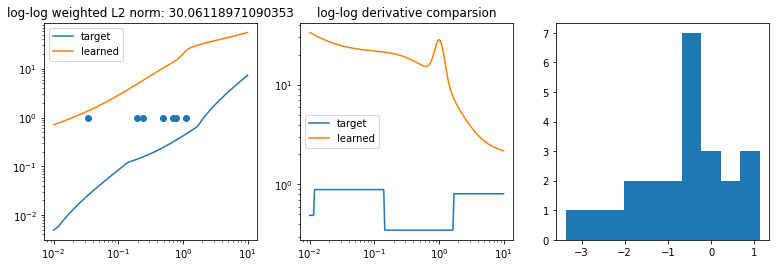

In [29]:
performance_check(generator)

epoch=0 generator_loss=4.554328 discriminator_loss=1.005586 real_acc=0.666667 fake_acc=1.000000


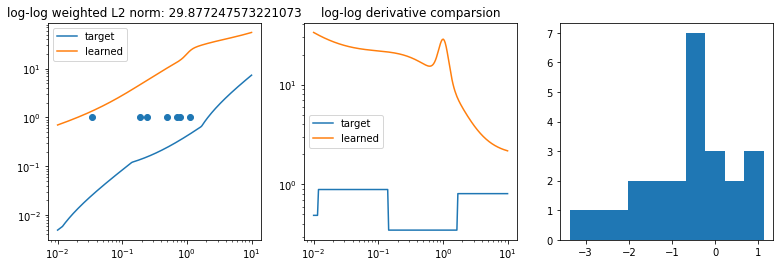

epoch=20 generator_loss=2.751459 discriminator_loss=0.684682 real_acc=0.700000 fake_acc=1.000000


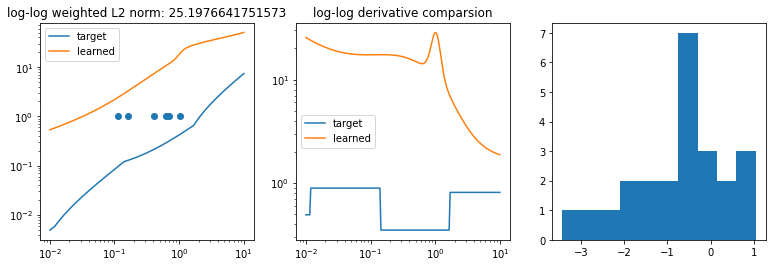

epoch=40 generator_loss=2.285587 discriminator_loss=0.587374 real_acc=0.700000 fake_acc=1.000000


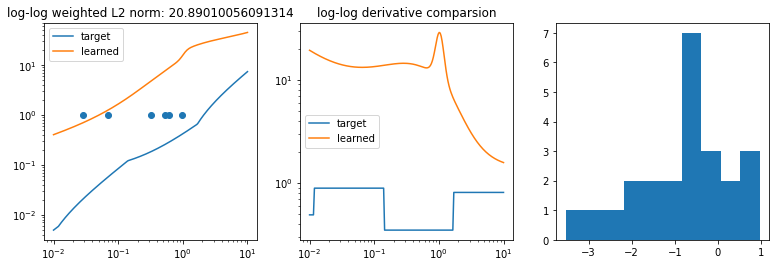

epoch=60 generator_loss=1.446710 discriminator_loss=0.650138 real_acc=0.633333 fake_acc=1.000000


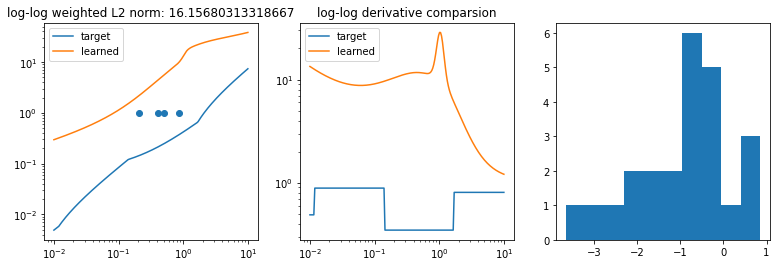

epoch=80 generator_loss=2.809919 discriminator_loss=0.650221 real_acc=0.600000 fake_acc=1.000000


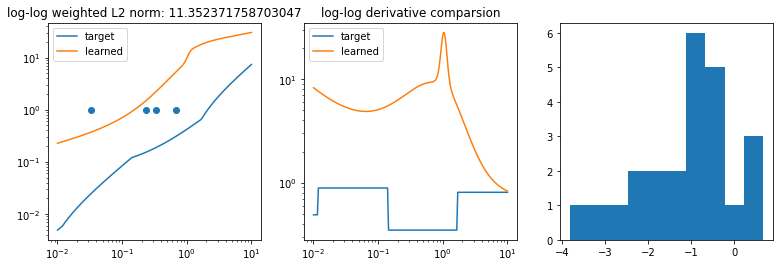

epoch=100 generator_loss=2.009795 discriminator_loss=0.551067 real_acc=0.733333 fake_acc=1.000000


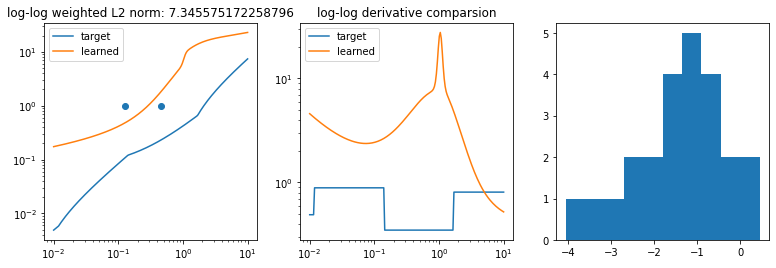

epoch=120 generator_loss=3.025495 discriminator_loss=0.589338 real_acc=0.700000 fake_acc=1.000000


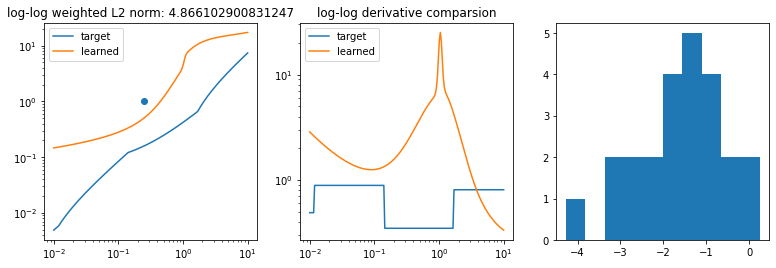

epoch=140 generator_loss=3.473168 discriminator_loss=0.444233 real_acc=0.866667 fake_acc=1.000000


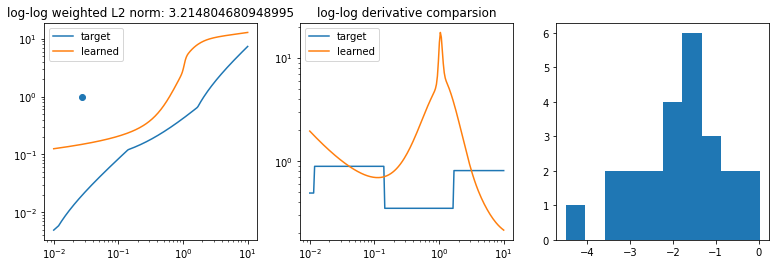

In [ ]:
%%time
mse = []
diff = []
d_loss = []
g_loss = []
real_acc = []
fake_acc = []
training(EPOCHES)

In [ ]:
w, v, b = generator.trainable_variables
x = tf.math.log(gen_gaps(w, v, b, 10000))
y = tf.math.log(gen_gaps_real(10000))
plt.hist(x.numpy().reshape(-1),label = 'fake')
plt.hist(y.numpy().reshape(-1), alpha=0.4,label='real')
plt.legend()

In [ ]:
plt.figure(figsize = (21,8))
plt.plot([i for i in range(len(g_loss))],np.array(g_loss),label='g_loss')
plt.plot([i for i in range(len(g_loss))],np.array(d_loss),label='d_loss')
plt.legend()
plt.show()

In [ ]:
B = 100
W = np.hamming(B)
W /= W.sum()
plt.figure(figsize = (21,8))
plt.plot([i for i in range(len(real_acc))],np.convolve(real_acc, W, mode='same'),label='real')
plt.plot([i for i in range(len(real_acc))],np.convolve(fake_acc, W, mode='same'),label='fake')
plt.legend()
plt.show()